O objetivo do código aqui é comparar os modelos no caso de um horizonte temporal $h = 1$

In [4]:
# Bibliotecas
import utils
import numpy as np
import pandas as pd
import epftools as epf
import forecasting_vars as fvars
import warnings
# Funções e classes do sktime e do sklearn
from sktime.forecasting.compose import make_reduction
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
# Modelos
from sktime.forecasting.arima import AutoARIMA
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [5]:
# Único ponto que muda entre arquivos h{i}.ipynb
FORECASTING_HORIZON = 1

# Importa dados sem lags
df = utils.read_and_change_index("dados/dados_transformados.csv")
df.head()

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,...,2481.49,0.4,49.609174,-2.34359,8.9,14.696341,348.7366,7.70,18.70,15.10
2004-02,0.61,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,...,29.00,0.3,121.394093,1.00000,-0.8,15.073171,0.0000,10.11,14.74,24.27
2004-03,0.47,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,...,2375.73,0.2,-166.416169,-5.00000,-10.1,16.078049,-10382.5684,4.04,2.71,10.95
2004-04,0.37,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,...,-1911.68,0.2,21.276658,-4.00000,-5.3,16.454878,-339.4192,-0.45,6.35,-11.13
2004-05,0.51,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,...,1488.90,0.2,14.892162,17.00000,16.2,15.324390,238.2590,-5.31,-15.02,8.03


In [6]:
# Cria cópia para usar para comparações depois
# Isso é um tanto de paranóia
ipca = df['ipca'].copy()
ipca_train, ipca_test = temporal_train_test_split(
    ipca,
    test_size=fvars.TEST_SIZE - FORECASTING_HORIZON + 1
)

In [7]:
# Benchmark
arima = AutoARIMA(sp=12, n_jobs=fvars.N_JOBS)
# Regressores
regressors = {
    'ridge': RidgeCV(),
    'lasso': LassoCV(max_iter=fvars.lasso['max_iter'], n_jobs=fvars.N_JOBS),
    'random_forest': RandomForestRegressor(max_features=fvars.rf['max_features'], n_jobs=fvars.N_JOBS),
    'lgbm': LGBMRegressor(
        n_estimators=fvars.lgbm['n_trees'],
        num_leaves=fvars.lgbm['n_leaves'],
        verbose=fvars.lgbm['verbose'],
        n_jobs=fvars.N_JOBS
    )
}
# Converte regressores com 'make_reduction'
forecasters = {}
for model, reg in regressors.items():
    forecasters[model] = make_reduction(reg, window_length=fvars.WINDOW_LENGTH)

In [8]:
# Roda o ARIMA
# Serve apenas para achar o tamanho da 'initial_window' e para métricas de erro depois
y_train, y_test = temporal_train_test_split(df['ipca'], test_size=fvars.TEST_SIZE)
fh = ForecastingHorizon(FORECASTING_HORIZON, is_relative=True)
cv = ExpandingWindowSplitter(fh, initial_window=y_train.size)
arima.fit(y_train)
# Ignora 'warnings' pois não há nada que eu possa fazer
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    # Aviso que os parâmetros no começo da estimação não são inversíveis
    # (no caso de MA) ou não são estacionários (no caso de AR) 
    warnings.simplefilter("ignore", UserWarning)  
    # Não roda com 'evaluate' pois os resultados são os mesmos,
    # mas assim consigo os parâmetros
    arima_pred = arima.update_predict(df['ipca'], cv=cv)
arima_pred

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\

2017-03    0.282510
2017-04    0.401124
2017-05    0.309435
2017-06    0.281415
2017-07    0.056204
             ...   
2023-05    0.519261
2023-06    0.320844
2023-07   -0.002215
2023-08    0.248564
2023-09    0.299311
Freq: M, Name: ipca, Length: 79, dtype: float64

In [9]:
arima.get_fitted_params()

{'intercept': 0.18020705236003967,
 'ar.L1': 0.6302824734799789,
 'ma.S.L12': 0.26778663675848924,
 'sigma2': 0.037347466580843036,
 'order': (1, 0, 0),
 'seasonal_order': (0, 0, 1, 12),
 'aic': -61.629373864985325,
 'aicc': -61.367935956488594,
 'bic': -49.37899373287746,
 'hqic': -56.65434023128604}

In [10]:
# Salva métricas de erro e previsões em dicionário
res = {}
preds = {} # Salva 'arima_pred' aqui depois de rodar teste DM
# Salva métricas de erro do ARIMA
mae = MeanAbsoluteError()
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
res['arima'] = [
    mae(ipca_test, arima_pred),
    mse(ipca_test, arima_pred),
    mape(ipca_test, arima_pred),
]
for model, forecaster in forecasters.items():
    mae = MeanAbsoluteError()
    mse = MeanSquaredError()
    mape = MeanAbsolutePercentageError()
    
    # Modelos lineares (precisam de dados normalizados)
    if model in fvars.LINEAR_MODELS:
        # Normaliza dados
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(df)
        normalized_df = pd.DataFrame(normalized_data, columns=df.columns, index=df.index)
        
        y_train, y_test, y_pred = utils.evaluate_pipeline(forecaster, normalized_df, FORECASTING_HORIZON)
        # Desnormaliza previsões
        y_pred = y_pred * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
        preds[model] = y_pred

    else:
        y_train, y_test, y_pred = utils.evaluate_pipeline(forecaster, df, FORECASTING_HORIZON)
        preds[model] = y_pred

    res[model] = [
        mae(ipca_test, y_pred),
        mse(ipca_test, y_pred),
        mape(ipca_test, y_pred)
    ]

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e-02, tolerance: 8.235e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-02, tolerance: 8.235e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [11]:
res_df = pd.DataFrame(res, index=['MAE', 'MSE', 'MAPE'])
res_df

,arima,ridge,lasso,random_forest,lgbm
MAE,0.281731,0.369303,0.270716,0.285119,0.289316
MSE,0.143799,0.235190,0.132406,0.144145,0.153760
MAPE,1.590837,2.011387,1.198820,1.287506,1.309678


In [16]:
p_values = {}
for model, pred in preds.items():
    p_values[model] = epf.DM(ipca_test, arima_pred, pred)
p_value_df = pd.DataFrame(p_values, index=['DM'])
p_value_df

e:\tcc\epftools.py:124: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


,ridge,lasso,random_forest,lgbm,arima
DM,0.998677,0.182267,0.584312,0.653401,NaN


In [ ]:
# Salva tabelas de testes no Excel
with pd.ExcelWriter(f"testes/h{FORECASTING_HORIZON}.xlsx") as writer:
    res_df.to_excel(writer, sheet_name="Erros")
    p_value_df.to_excel(writer, sheet_name="Diebold-Mariano")

In [13]:
preds['arima'] = arima_pred
preds_df = pd.DataFrame(preds, index=y_test.index).dropna() # Necessário para h > 1
preds_df.head()

,ridge,lasso,random_forest,lgbm,arima
month,,,,,
2017-03,0.648333,0.405878,0.3409,0.359410,0.282510
2017-04,0.540473,0.421398,0.3775,0.445477,0.401124
2017-05,0.084583,0.116601,0.2328,0.107960,0.309435
2017-06,-0.014598,0.189782,0.2026,0.174171,0.281415
2017-07,0.007576,0.047469,0.2588,0.153869,0.056204


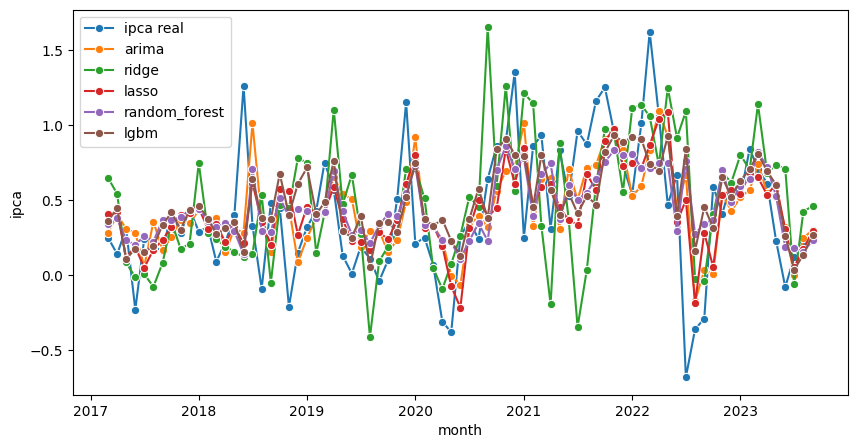

In [14]:
labels = ['ipca real', 'arima', 'ridge', 'lasso', 'random_forest', 'lgbm']
fig, ax = utils.plot_series(
    ipca_test,
    preds['arima'],
    preds['ridge'],
    preds['lasso'],
    preds['random_forest'],
    preds['lgbm'],
    labels=labels,
    figsize=fvars.FIGSIZE
)
fig.savefig(f"imagens/h{FORECASTING_HORIZON}.png")

In [15]:
preds_df.to_csv(f"previsões/h{FORECASTING_HORIZON}.csv", sep=';', decimal=',')